
### Importing Required libraries



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imutils

import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm
import os
import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings


### Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/Final Processed Images"

'Crack and Groove Dataset '   'Rut and Subsidence Dataset'  'Subsidence(ready)'
'Cracks (no further action)'  'Rut (less res)'
'Groove (no further action)'  'Rut (ready)'


In [ ]:
!unrar x "/content/drive/MyDrive/Final Processed Images/Rut and Subsidence Dataset/Rut-Subsidence-Train-Val-Split-80-20-New.rar"
!unrar x "/content/drive/MyDrive/Final Processed Images/Rut and Subsidence Dataset/Rut+Subsidence -Test-NEW.rar"

In [ ]:
Training_images_path = "Rut-Subsidence-Train-Val-Split-80-20-New/train"
Validation_images_path = "Rut-Subsidence-Train-Val-Split-80-20-New/val"
Testing_images_path = "Rut+Subsidence -Test-NEW/test"

In [ ]:
class_map = {0:'Rut',
             1:'Susbsidence'}
SIZE = 224

In [ ]:
def Collect_data_from_folder (path):
  #Capture training data and labels into respective lists
  images = []
  labels = [] 
  for directory_path in glob.glob(path+"/*"):
      label = directory_path.split("/")[-1]
      print(label)
      for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):

          
          img = cv2.imread(img_path)
          img = img/255
          img = np.float32(img)
          img = cv2.resize(img, (SIZE, SIZE))
          #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img = img - np.mean(img)
          img = img/np.std(img)
          #img = cv2.GaussianBlur(img,(5,5),0)
          images.append(img)
          labels.append(label)


  #Convert lists to arrays        
  images = np.array(images)
  labels = np.array(labels)
  return images, labels


In [ ]:
train_images, train_labels = Collect_data_from_folder(Training_images_path)
val_images, val_labels = Collect_data_from_folder(Validation_images_path)

Rut
Subsidence
Rut
Subsidence


### Augmentation

In [ ]:
def DataAugmentation_Object():
    return tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=0.2,zoom_range=0.01,horizontal_flip=True,vertical_flip=True,rescale=None)
def augmentated_images(images,labels):
   images_after_aug = []
   labels_after_aug = []
   augmentation_object = DataAugmentation_Object()
   for j in range(len(images)):
    for i in range(1):
            if(i==0):
               images_after_aug.append(np.reshape(images[j], (SIZE, SIZE, 3)))
               labels_after_aug.append(labels[j])
            
            img = augmentation_object.flow(np.reshape(images[j], (1, SIZE, SIZE, 3))).next()
            images_after_aug.append(np.reshape(img, (SIZE, SIZE, 3)))
            labels_after_aug.append(labels[j])
            

    #for j in range(len(images)):
                   
   labels_after_aug = np.asarray(labels_after_aug)
   images_after_aug = np.asarray(images_after_aug)
   return images_after_aug, labels_after_aug

In [ ]:
images_after_aug, labels_after_aug = augmentated_images(train_images, train_labels)

train_images = images_after_aug 
train_labels = labels_after_aug

'''val_images_after_aug, val_labels_after_aug = augmentated_images(val_images, val_labels)

val_images = val_images_after_aug 
val_labels = val_labels_after_aug''';

### Shuffle the Dataset

In [ ]:
import random

In [ ]:
random.shuffle([train_images, train_labels])

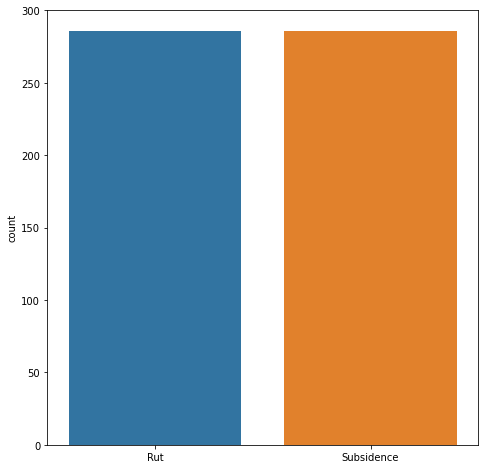

In [ ]:
plt.figure(figsize = (17,8));
for i,j in enumerate([train_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);

In [ ]:
test_images, test_labels = Collect_data_from_folder (Testing_images_path)

Rut
Subsidence


In [ ]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
le.fit(val_labels)
val_labels_encoded = le.transform(val_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test,  x_val, y_val = train_images, train_labels_encoded, test_images, test_labels_encoded, val_images, val_labels_encoded
del train_images, train_labels_encoded, test_images, test_labels_encoded


In [ ]:
print(f'Training shape : {x_train.shape}')
print(f'validating shape : {x_val.shape}')
print(f'Testing shape : {x_test.shape}')

Training shape : (572, 224, 224, 3)
validating shape : (72, 224, 224, 3)
Testing shape : (40, 224, 224, 3)


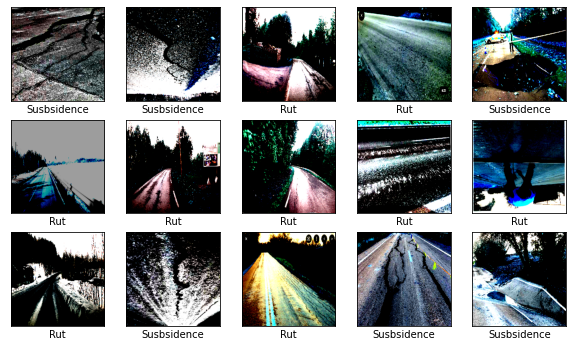

In [ ]:
plt.figure(figsize=(10,10))
for j in range(15):
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    i = random.randint(0,len(x_train))
    img = np.clip(x_train[i], 0, 1)
    plt.imshow(img, cmap=plt.cm.binary_r)
    #print(y_train[i])
    plt.xlabel(class_map[y_train[i]])
plt.show()

In [ ]:
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
session.as_default()


In [ ]:

BATCH_SIZE = 32
EPOCHS = 100
INIT_LR = 5e-3
MAX_LR = 1e-3
Lr = 1e-3

In [ ]:

from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x = x_set 
        self.y = y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return batch_x, batch_y

In [ ]:
train_gen = DataGenerator(x_train, y_train, BATCH_SIZE)
val_gen   = DataGenerator(x_val,   y_val,   BATCH_SIZE)
test_gen  = DataGenerator(x_test,  y_test,  BATCH_SIZE)

### Transfer Learning


In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(SIZE,SIZE,3))
model = effnet.output
model= tf.keras.layers.Dropout(0.8)(model)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(256,activation='relu')(model)
model = tf.keras.layers.Dense(128,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(2,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, mode='auto'),
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_accuracy', mode = 'max', restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint("/content/bestmodel.hdf5", monitor='val_accuracy', save_best_only=True,mode='max', save_freq='epoch')]
                             


In [ ]:
import tensorflow.keras.backend as KB

with session.as_default():
  KB.clear_session()
  model.compile(optimizer=opt,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
history_all = {}
with session.as_default():
  history = model.fit(train_gen, validation_data=val_gen, epochs =50,verbose=1, batch_size=BATCH_SIZE,callbacks=callbacks)
  

In [ ]:
model.load_weights("/content/bestmodel.hdf5")


### Evaluating the model

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)


2/2 [==============================] - 2s 442ms/step


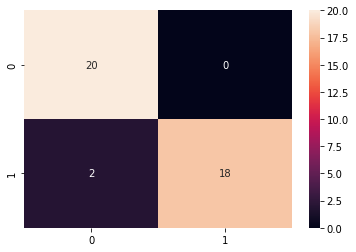

In [ ]:
import seaborn as sns
sns.heatmap(tf.math.confusion_matrix(y_test,pred,), annot=True)

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.90      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
print(f'f1_score : {f1_score(y_test, pred)}')
print(f'recall : {recall_score(y_test, pred)}')
print(f'precision : {precision_score(y_test, pred)}')


f1_score : 0.9473684210526316
recall : 0.9
precision : 1.0


### Misclassification

In [ ]:
# Constructs a list of misclassified images given a list of test images and their labels
def get_misclassified_images(x_test, true_label, predicted_label):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for i in range(len(true_label)):

        # Get true data
        im = x_test[i]

        # Compare true and predicted labels 
        if(predicted_label[i] != true_label[i]):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label,i))
            
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels

In [ ]:
# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(x_test,y_test, pred)

# Accuracy calculations
total = len(x_test)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))

Accuracy: 0.95
Number of misclassified images = 2 out of 40


In [ ]:
# Visualize misclassified example(s)
## TODO: Display an image in the `MISCLASSIFIED` list 
## TODO: Print out its predicted label - to see what the image *was* incorrectly classified as5
num = 0
test_mis_im = MISCLASSIFIED[num][0]
index_ = []
for index in range(len(MISCLASSIFIED)):
    image = MISCLASSIFIED[index][0]
    label_true = MISCLASSIFIED[index][1]
    label_guess = MISCLASSIFIED[index][2]
    index_.append( MISCLASSIFIED[index][3])

print(index_)


[21, 30]
